In [1]:
import ND_north_star.src.noise_generators.perlin_noise_generator as PNG

import ND_north_star.src.edge_detection.complex as ED_com
from ND_north_star.src.edge_detection.contour_points_2D import find_boundary_points, group_distinct_boundary_curves, generate_spline_curve, generate_boundary_splines
import ND_north_star.src.edge_detection.gradient_detection as ED_sim

from ND_north_star.src.utils.sampling_function import random_sampler


In [2]:
resolution = 80
dimensions = [resolution, resolution]

full_dataset = PNG.normalized_perlin_data(dimensions, 2)

# Plot perlin noise coord in x and y coordinates and with intensity values surrounded by a black outline
# PNG.plot_perlin_2D_3D(full_dataset, 'black')

# dataset = random_sampler(full_dataset, 200)
# PNG.plot_perlin_2D_3D(dataset, 'black')

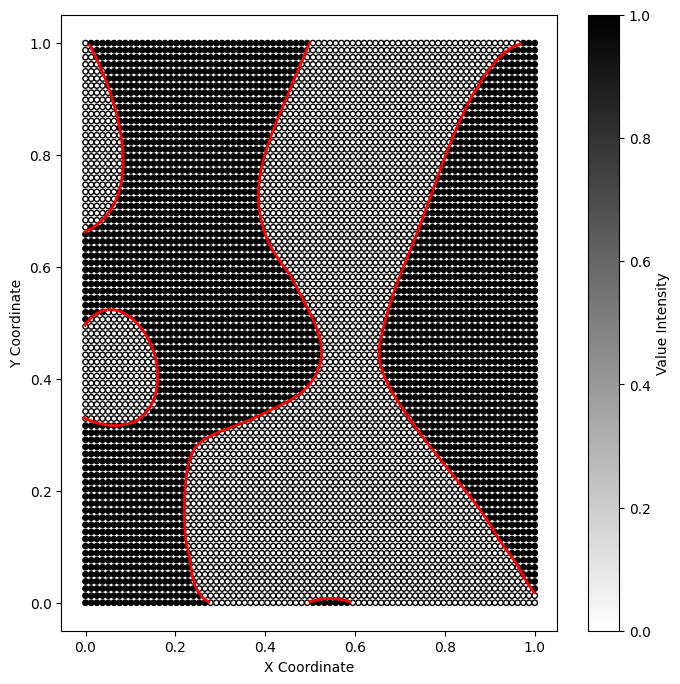

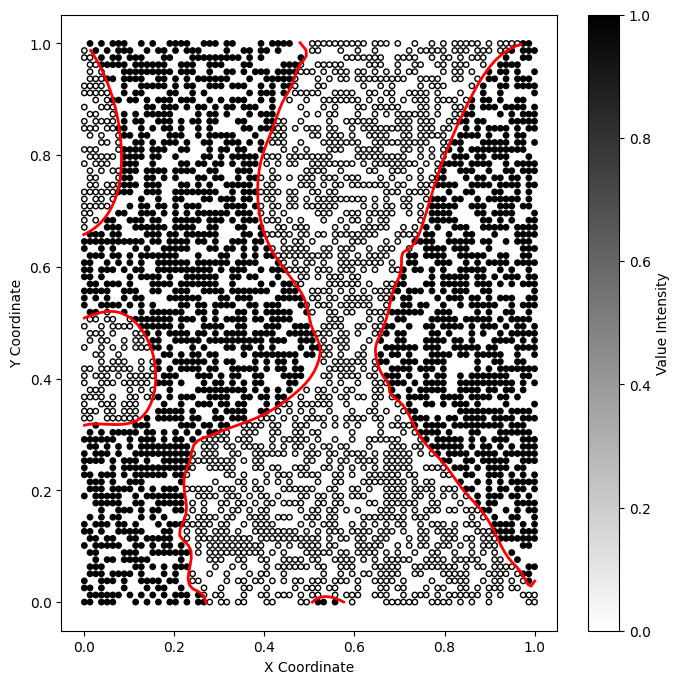

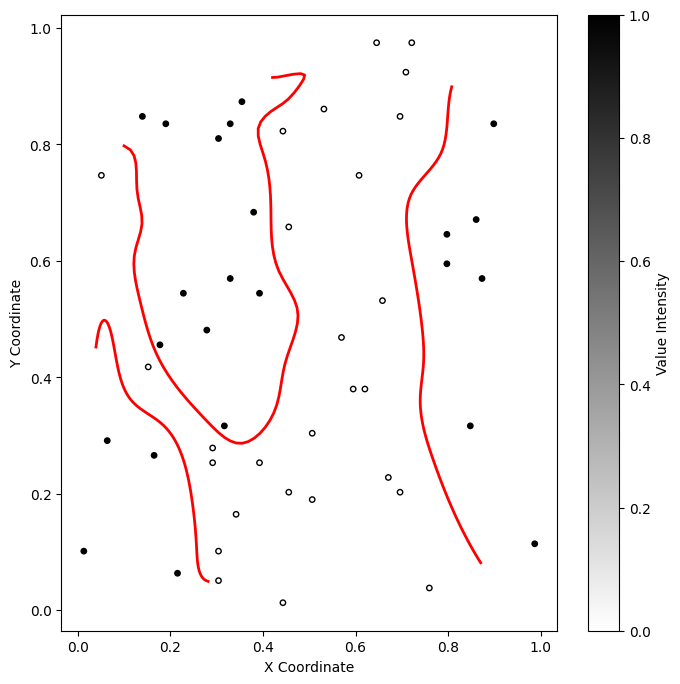

In [3]:


boundary_splines = generate_boundary_splines(full_dataset)
full_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(full_dataset, 'black')

close_dataset = random_sampler(full_dataset, 3800)
boundary_splines = generate_boundary_splines(close_dataset)
close_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(close_dataset, 'black')


sparse_dataset = random_sampler(full_dataset, 50)
boundary_splines = generate_boundary_splines(sparse_dataset)
sparse_dataset['boundary_splines'] = boundary_splines
PNG.plot_perlin_2D_3D(sparse_dataset, 'black')





In [4]:
print(full_dataset['boundary_splines'])

{0: array([[-0.00375333,  0.33044453],
       [ 0.00149335,  0.32844064],
       [ 0.00676679,  0.32659056],
       [ 0.01205961,  0.32489502],
       [ 0.01736444,  0.32335476],
       [ 0.02267392,  0.32197051],
       [ 0.02798066,  0.32074301],
       [ 0.0332773 ,  0.319673  ],
       [ 0.03855647,  0.31876121],
       [ 0.04381081,  0.31800838],
       [ 0.04903293,  0.31741524],
       [ 0.05421548,  0.31698252],
       [ 0.05935108,  0.31671097],
       [ 0.06443236,  0.31660132],
       [ 0.06945195,  0.31665429],
       [ 0.07440249,  0.31687064],
       [ 0.07927659,  0.3172511 ],
       [ 0.0840669 ,  0.31779639],
       [ 0.08876604,  0.31850726],
       [ 0.09336665,  0.31938444],
       [ 0.09786134,  0.32042867],
       [ 0.10224276,  0.32164068],
       [ 0.10650353,  0.32302121],
       [ 0.11063629,  0.32457099],
       [ 0.11463366,  0.32629076],
       [ 0.11848827,  0.32818126],
       [ 0.12219275,  0.33024321],
       [ 0.12573974,  0.33247736],
       [ 0.12912

In [5]:
import numpy as np

merged_array = np.concatenate(list(full_dataset['boundary_splines'].values()), axis=0)
print(merged_array)

[[-3.75333450e-03  3.30444528e-01]
 [ 1.49335493e-03  3.28440638e-01]
 [ 6.76679452e-03  3.26590556e-01]
 [ 1.20596144e-02  3.24895017e-01]
 [ 1.73644448e-02  3.23354756e-01]
 [ 2.26739157e-02  3.21970510e-01]
 [ 2.79806573e-02  3.20743014e-01]
 [ 3.32772998e-02  3.19673003e-01]
 [ 3.85564733e-02  3.18761213e-01]
 [ 4.38108079e-02  3.18008379e-01]
 [ 4.90329337e-02  3.17415236e-01]
 [ 5.42154810e-02  3.16982521e-01]
 [ 5.93510798e-02  3.16710969e-01]
 [ 6.44323603e-02  3.16601315e-01]
 [ 6.94519526e-02  3.16654295e-01]
 [ 7.44024868e-02  3.16870644e-01]
 [ 7.92765932e-02  3.17251098e-01]
 [ 8.40669017e-02  3.17796392e-01]
 [ 8.87660427e-02  3.18507262e-01]
 [ 9.33666461e-02  3.19384443e-01]
 [ 9.78613422e-02  3.20428672e-01]
 [ 1.02242761e-01  3.21640682e-01]
 [ 1.06503533e-01  3.23021210e-01]
 [ 1.10636288e-01  3.24570992e-01]
 [ 1.14633656e-01  3.26290762e-01]
 [ 1.18488267e-01  3.28181257e-01]
 [ 1.22192752e-01  3.30243211e-01]
 [ 1.25739740e-01  3.32477361e-01]
 [ 1.29121917e-01  3

In [6]:
import numpy as np
from hausdorff import hausdorff_distance

ind = 2

X1 = np.concatenate(list(full_dataset['boundary_splines'].values()), axis=0)
X2 = np.concatenate(list(close_dataset['boundary_splines'].values()), axis=0)
X3 = np.concatenate(list(sparse_dataset['boundary_splines'].values()), axis=0)

# print(X.shape)

print(f"Hausdorff distance test: {hausdorff_distance(X1, X2, distance='euclidean')}")
print(f"Hausdorff distance test: {hausdorff_distance(X1, X3, distance='euclidean')}")


Hausdorff distance test: 0.01824627394792893
Hausdorff distance test: 0.29139890788474804


In [7]:
import numpy as np
from hausdorff import hausdorff_distance

# two random 2D arrays (second dimension must match)
np.random.seed(0)



X = full_dataset['boundary_splines'][0]
Y = dataset['boundary_splines'][0]

print(X.shape)
# print(X)

# Test computation of Hausdorff distance with different base distances
# print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='manhattan')}")
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='euclidean')}")
# print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='chebyshev')}")
# print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='cosine')}")

# # For haversine, use 2D lat, lng coordinates
# def rand_lat_lng(N):
#     lats = np.random.uniform(-90, 90, N)
#     lngs = np.random.uniform(-180, 180, N)
#     return np.stack([lats, lngs], axis=-1)
        
# X = rand_lat_lng(100)
# Y = rand_lat_lng(250)
# print("Hausdorff haversine test: {0}".format( hausdorff_distance(X, Y, distance="haversine") ))

NameError: name 'dataset' is not defined

In [ ]:
import numpy as np
from hausdorff import hausdorff_distance

# two random 2D arrays (second dimension must match)
np.random.seed(0)
X = np.random.random((1000,2))
Y = np.random.random((5000,2))

print(X.shape)
print(X)

# Test computation of Hausdorff distance with different base distances
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='manhattan')}")
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='euclidean')}")
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='chebyshev')}")
print(f"Hausdorff distance test: {hausdorff_distance(X, Y, distance='cosine')}")

# For haversine, use 2D lat, lng coordinates
def rand_lat_lng(N):
    lats = np.random.uniform(-90, 90, N)
    lngs = np.random.uniform(-180, 180, N)
    return np.stack([lats, lngs], axis=-1)
        
X = rand_lat_lng(100)
Y = rand_lat_lng(250)
print("Hausdorff haversine test: {0}".format( hausdorff_distance(X, Y, distance="haversine") ))

(1000, 2)
[[0.5488135  0.71518937]
 [0.60276338 0.54488318]
 [0.4236548  0.64589411]
 ...
 [0.41443887 0.79128155]
 [0.72119811 0.48010781]
 [0.64386404 0.50177313]]
Hausdorff distance test: 0.062454548094708184
Hausdorff distance test: 0.053084345565014415
Hausdorff distance test: 0.05223899206749627
Hausdorff distance test: 1.5204074512387145e-05
Hausdorff haversine test: 2788.207575653002


In [ ]:
import matplotlib.pyplot as plt

X = boundary_points[:, 0]
Y = boundary_points[:, 1]

plt.scatter(X, Y, s=3)
plt.show()

NameError: name 'boundary_points' is not defined

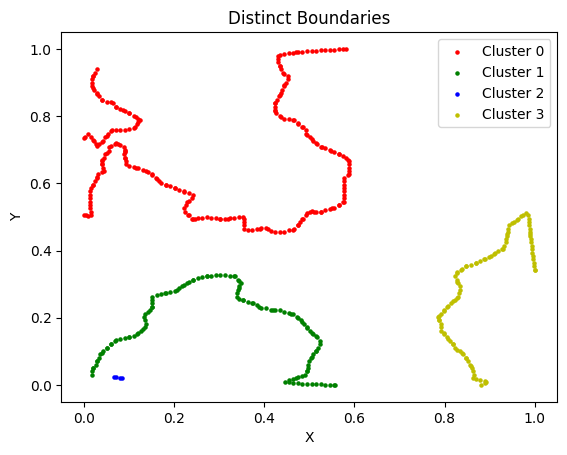

In [ ]:

distinct_boundaries = group_distinct_boundary_curves(boundary_points)

# Plotting the results to visualize the clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for label, boundary in distinct_boundaries.items():
    if label == -1:
        color = 'k'  # Noise points
    else:
        color = colors[label % len(colors)]
        plt.scatter(boundary[:, 0], boundary[:, 1], c=color, label=f'Cluster {label}', s=5)
        # plt.show()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distinct Boundaries')
plt.legend()
plt.show()

# # Print distinct boundaries
# for label, boundary in distinct_boundaries.items():
#     print(f"Boundary {label}:")
#     print(boundary)

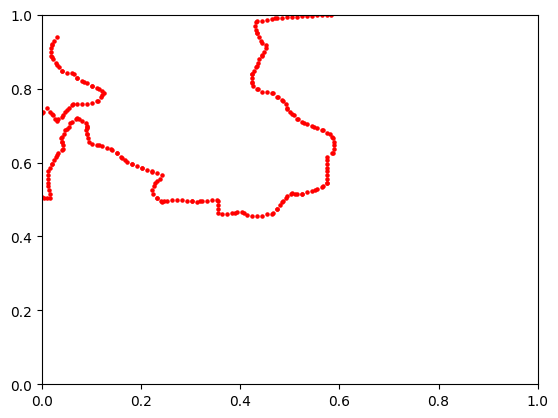

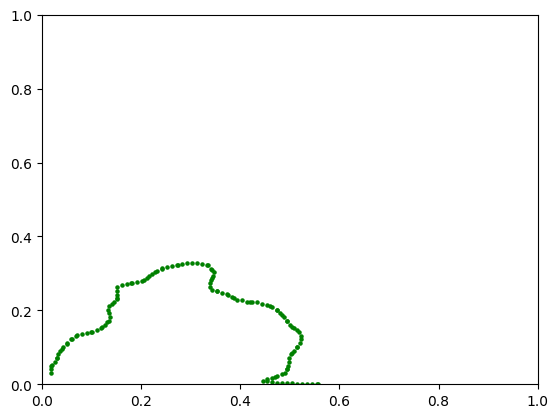

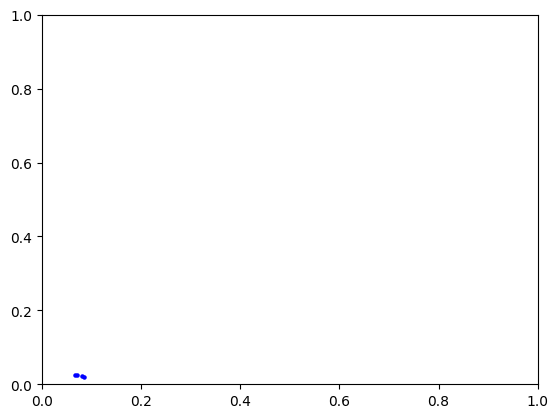

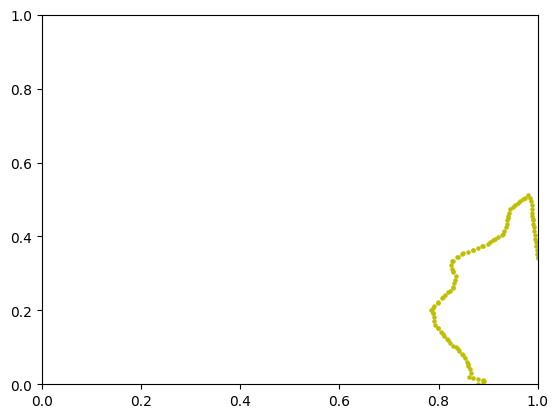

In [ ]:

distinct_boundaries = group_distinct_boundary_curves(boundary_points)

# Plotting the results to visualize the clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for label, boundary in distinct_boundaries.items():
    if label == -1:
        color = 'k'  # Noise points
    else:
        color = colors[label % len(colors)]
        plt.scatter(boundary[:, 0], boundary[:, 1], c=color, label=f'Cluster {label}', s=5)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Distinct Boundaries')
# plt.legend()
# plt.show()


In [ ]:
# print(len(distinct_boundaries))
# print(distinct_boundaries.keys())
# print(distinct_boundaries)


265 265
50 50


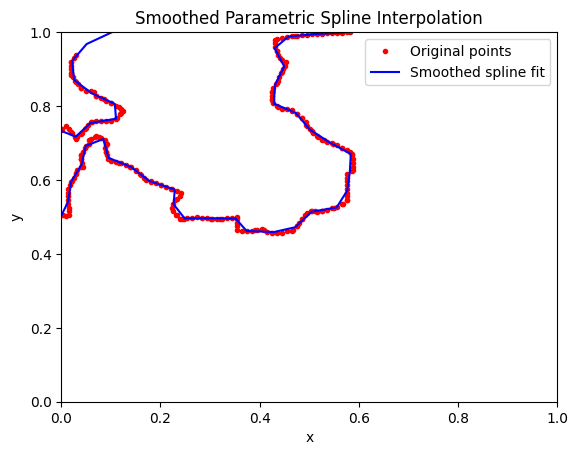

133 133
50 50


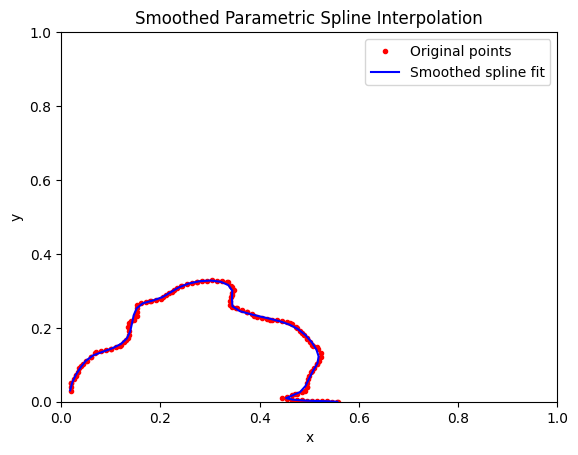

4 4
50 50


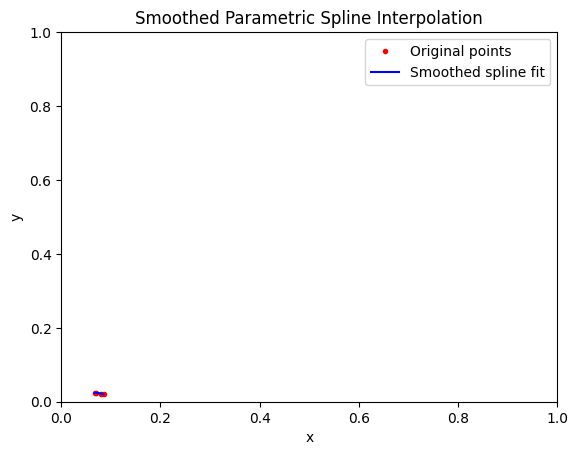

104 104
50 50


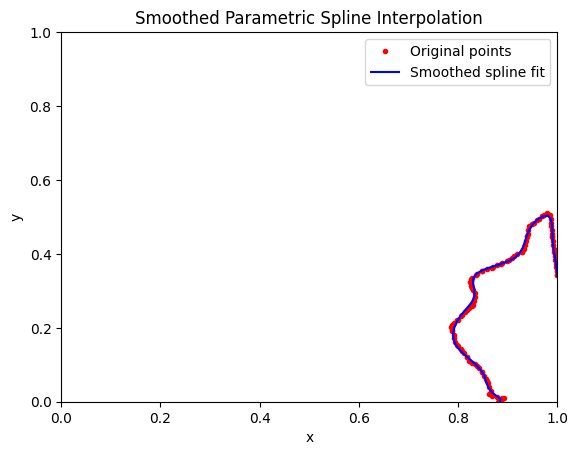

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import splprep, splev



# def generate_spline_curve(points, smoothing_factor=0.001, num_points=100):

#     # Split data into x and y coordinates
#     x = points[:, 0]
#     y = points[:, 1]

#     # Parameterize the points with a parameter t
#     t = np.linspace(0, 1, len(points))

#     # Fit splines to x(t) and y(t) with smoothing factor s
#     # smoothing_factor = .001  # Adjust this value for more or less smoothing
#     tck, u = splprep([x, y], s=smoothing_factor)

#     # Evaluate the spline fit at a dense set of parameter values
#     # num_points = 100  # Number of points in the final smoothed curve
#     x_new, y_new = splev(np.linspace(0, 1, num_points), tck)

#     return x_new, y_new





for ind, points in distinct_boundaries.items():
# # Sample data points
# points = distinct_boundaries[4]  # Adjust this based on your actual data

    x = points[:, 0]
    y = points[:, 1]
    
    x_new, y_new = generate_spline_curve(points, smoothing_factor=0.001, num_points=50)

    print(len(x), len(y))
    print(len(x_new), len(y_new))

    # Plot the original points and the fitted curve
    plt.figure()
    plt.plot(x, y, 'ro', label='Original points', markersize=3)
    plt.plot(x_new, y_new, 'b-', label='Smoothed spline fit')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Smoothed Parametric Spline Interpolation')
    plt.show()